# Machine Learning: ABALONE
### Authors: Martín Blázquez Moreno & Juan Rafael Caro Romero

### [Click here to see ABALONE dataset](https://archive.ics.uci.edu/ml/datasets/Abalone)

In [14]:
#Import all libraries
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

## Digits Dataset

In [15]:
#Load digits dataset
digits = load_digits()
print(digits.data.shape)

(1797, 64)


This dataset contains images (8x8 pixels) of hand written numbers using 4 bits representation (gray scale). Each target class corresponds a digit from 0 to 9. There are 1797 samples with different numbers and 64 features (columns).

<Figure size 432x288 with 0 Axes>

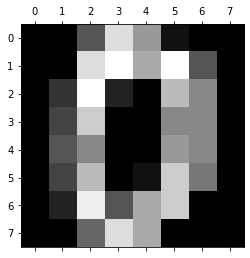

In [16]:
#Example of image
plt.gray()
plt.matshow(digits.images[0]) 
plt.show() 

In [17]:
#Split data on two variables
X = digits.data #features
y = digits.target #target
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


In [18]:
#Distribution of samples by class
for i in range(10):
    print(i, " ",sum(y==i)/digits.data.shape[0]*100)

0   9.905397885364495
1   10.127991096271565
2   9.84974958263773
3   10.18363939899833
4   10.072342793544797
5   10.127991096271565
6   10.072342793544797
7   9.961046188091263
8   9.68280467445743
9   10.01669449081803


In [19]:
#split the data in test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print("Without stratify: ")
print()
for i in range(10):
    print(i, " ",sum(y_train==i)/y_train.shape[0]*100)
print()

#split the data in test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)
print("With stratify: ")
print()
for i in range(10):
    print(i, " ",sum(y_train==i)/y_train.shape[0]*100)

Without stratify: 

0   9.812108559498958
1   10.299234516353515
2   9.951287404314545
3   9.951287404314545
4   10.22964509394572
5   10.438413361169102
6   10.020876826722338
7   9.672929714683368
8   9.812108559498958
9   9.812108559498958

With stratify: 

0   9.88169798190675
1   10.160055671537926
2   9.88169798190675
3   10.160055671537926
4   10.090466249130133
5   10.090466249130133
6   10.090466249130133
7   9.951287404314545
8   9.672929714683368
9   10.020876826722338


The distribution of the samples is the same with and without the stratification process due to the dataset is already compensated.

The next step is to scaling the data before the process of decreasing the dimensionality of the dataset. This method is named as Principal Component Analysis (PCA). This process may reduce the accuracy of the model due to you need to convert some features.

In [20]:
#Scalling the data
miStdScaler = StandardScaler() 
X_train = miStdScaler.fit_transform(X_train) #overwrite X_train with the new features
X_test = miStdScaler.transform(X_test) #overwrite X_test with the new features

We want to know the loss of variance depending the number of dimension loss.

In [21]:
def plot_lossPCA(dataTr, dataT):
    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_ylabel('Variance')
    ax.set_xlabel('Decreasing dimension')
    for i in range (dataTr.shape[1]):
        miPCA = PCA(n_components=i)
        miPCA.fit(dataTr)
        dataTr_pca = miPCA.transform(dataTr)
        dataT_pca = miPCA.transform(dataT)
        ax.bar(i,sum(miPCA.explained_variance_ratio_),color='g')
    plt.show()
        #print("Dimension decrease: ", i," ",sum(miPCA.explained_variance_ratio_))

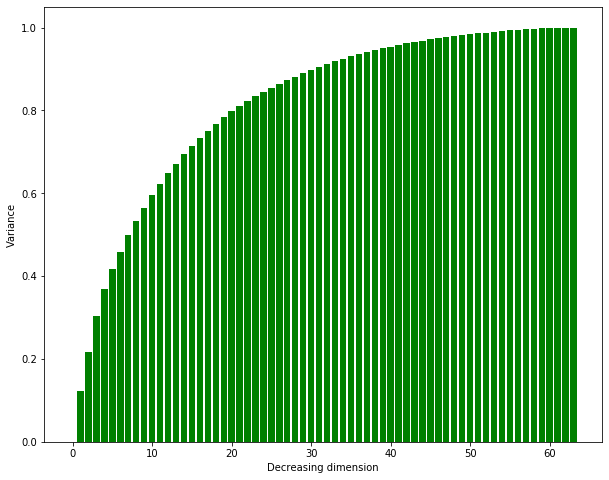

In [22]:
plot_lossPCA(X_train, X_test)

Exist a parameter in the random forest model which tell us the importance of each feature in the dataset. With this parameter we can select the right number of components in the PCA.

In [23]:
def modRF(ytest, ytrain, xtest, xtrain):   
    miModelo = RandomForestClassifier()    
    migrid = {'n_estimators':[10,30,50,100]}
    migscv = GridSearchCV(estimator=miModelo,param_grid=migrid,scoring='accuracy',cv=10,n_jobs=-1)
    migscv.fit(xtrain,ytrain)
    midtopt = migscv.best_estimator_
    midtopt.fit(xtrain,ytrain)
    y_pred = midtopt.predict(X_test)    
    print('Random Forest Model accuracy:',100*accuracy_score(y_test,y_pred))
    
    t = sum(migscv.cv_results_['mean_score_time']) + sum(migscv.cv_results_['mean_fit_time'])
    
        
    return t,midtopt

In [24]:
t,rf = modRF(y_test,y_train, X_test, X_train)

Random Forest Model accuracy: 97.5


1.0000000000000004


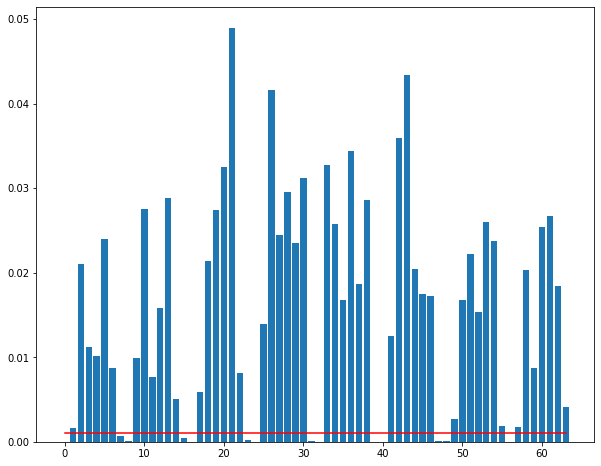

In [25]:
print(sum(rf.feature_importances_))
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(np.arange(64),rf.feature_importances_)
ax.plot(np.arange(64),np.full((64,),0.001),'r-')

The graph above show the importance of each feature. We decided to count the 
number of features that exceed the value of 0.001 but also will check with other numbers of dimensions for comparasion.

In [26]:
print("Number of relevant features: ", sum(rf.feature_importances_ > 0.001))

Number of relevant features:  50


### Analysis with KNN Models

Now we can select the correct number of dimension loss that adjust to our problem. Also we want to generalizate the different models with inputs parameters.

In [27]:
def modKNN(n,grid,ytest,ytrain,xtest,xtrain):
    miPCA = PCA(n_components=n)
    miPCA.fit(X_train)
    X_train_pca = miPCA.transform(X_train)
    X_test_pca = miPCA.transform(X_test)
    
    mimod = KNeighborsClassifier()
    migscv = GridSearchCV(estimator=mimod,param_grid=grid,scoring='accuracy',cv=10,n_jobs=-1) #10-fold
    migscv.fit(X_train_pca,ytrain)
    miknnopt = migscv.best_estimator_
    miknnopt.fit(X_train_pca,ytrain)
    y_pred = miknnopt.predict(X_test_pca)
    
    test_acc = 100*accuracy_score(ytest,y_pred)
    
    if(len(grid)>=3):
        print("Accuracy:",test_acc, \
          'KNN (',miknnopt.n_neighbors,'/',miknnopt.weights,'/',miknnopt.metric,') with n_components: ',n)
    else:
        print("Accuracy:",test_acc, \
          'KNN (',miknnopt.n_neighbors,'/',miknnopt.weights,') with n_components: ',n)
    
    t = sum(migscv.cv_results_['mean_score_time']) + sum(migscv.cv_results_['mean_fit_time'])
    
    if(n==2):
        plt.figure(figsize=(15, 8))
        plt.subplot(121)
        plt.scatter(X_train_pca[:,0],X_train_pca[:,1],s=80,c=ytrain,cmap='Paired')
        
        X_test_pca = miPCA.transform(xtest)
        plt.scatter(X_test_pca[:,0],X_test_pca[:,1],s=80,marker='s',c=ytest,cmap='Paired')
        
        plt.subplot(122)
        plt.scatter(X_train_pca[:,0],X_train_pca[:,1],s=80,c=ytrain,cmap='Paired')
        plt.scatter(X_test_pca[:,0],X_test_pca[:,1],s=80,marker='s',c=y_pred,cmap='Paired')
        
        x_min, x_max = X_train_pca[:, 0].min(), X_train_pca[:, 0].max()
        y_min, y_max = X_train_pca[:, 1].min(), X_train_pca[:, 1].max()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
        
        Z = miknnopt.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        plt.contourf(xx, yy, Z, alpha=0.3,cmap='Paired')
        
    return t,test_acc

The only case that it's possible to plot the data is when the dimension decrease to 2.
In this first aproach, we add to the cross validation grid the K parameter (n_neighbors). Also, we store the mean time need it to execute the grid to compare them between the different models.

Accuracy: 56.666666666666664 KNN ( 9 / uniform ) with n_components:  2
Accuracy: 92.77777777777779 KNN ( 3 / uniform ) with n_components:  10
Accuracy: 96.38888888888889 KNN ( 3 / uniform ) with n_components:  30
Accuracy: 96.94444444444444 KNN ( 5 / uniform ) with n_components:  50


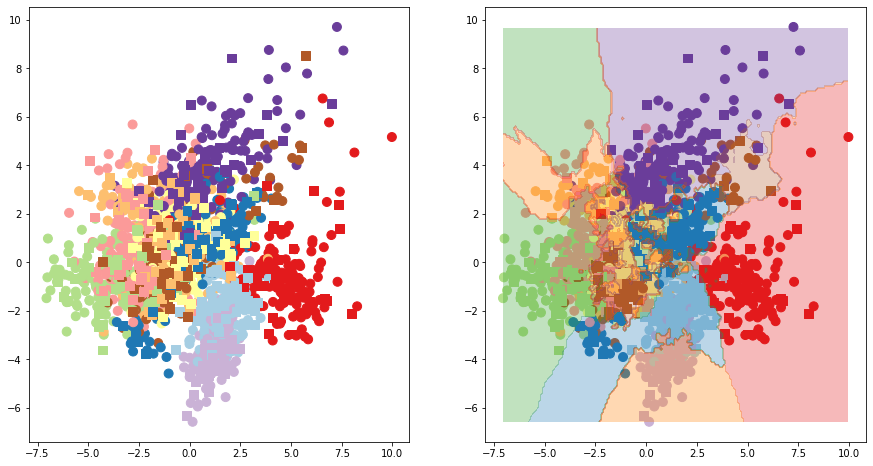

In [28]:
dimensions = [2, 10, 30, 50]
time_grid = np.zeros(len(dimensions))
acc = np.zeros(len(dimensions))

migrid = {'n_neighbors':[3,5,7,9],'weights':['uniform']}

for i, v in enumerate(dimensions):
    time_grid[i], acc[i] = modKNN(v,migrid,y_test,y_train, X_test, X_train)

dataT = {'Dimensions': [2,10,30,50], 'KNN uniform': time_grid}
dataA = {'Dimensions': [2,10,30,50], 'KNN uniform': acc}

df_time = pd.DataFrame(dataT)
df_accuracy = pd.DataFrame(dataA)

Now we want to check the differences between this first aproach and anothers cahning some parameters.

Accuracy: 54.166666666666664 KNN ( 9 / distance ) with n_components:  2
Accuracy: 92.77777777777779 KNN ( 3 / distance ) with n_components:  10
Accuracy: 96.38888888888889 KNN ( 5 / distance ) with n_components:  30
Accuracy: 96.94444444444444 KNN ( 5 / distance ) with n_components:  50


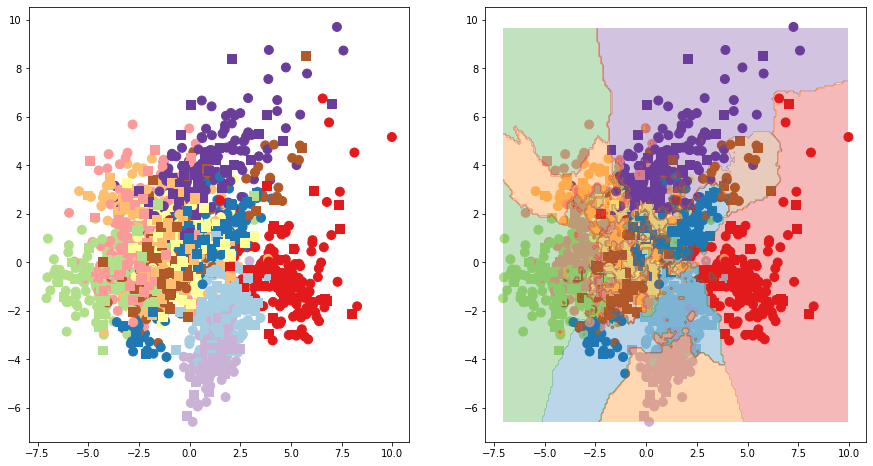

In [29]:
dimensions = [2, 10, 30, 50]
time_grid = np.zeros(len(dimensions))
acc = np.zeros(len(dimensions))

migrid = {'n_neighbors':[3,5,7,9],'weights':['distance']}

for i, v in enumerate(dimensions):
    time_grid[i], acc[i] = modKNN(v,migrid,y_test,y_train, X_test, X_train)

df_time['KNN distance'] = time_grid
df_accuracy['KNN distance'] = acc

Accuracy: 55.55555555555556 KNN ( 9 / uniform / minkowski ) with n_components:  2
Accuracy: 93.05555555555556 KNN ( 3 / distance / euclidean ) with n_components:  10
Accuracy: 96.38888888888889 KNN ( 5 / distance / euclidean ) with n_components:  30
Accuracy: 96.94444444444444 KNN ( 5 / distance / euclidean ) with n_components:  50


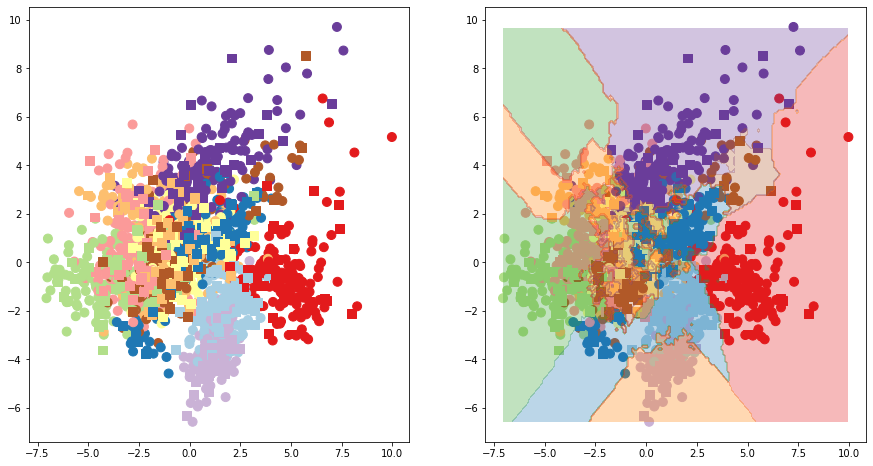

In [30]:
dimensions = [2, 10, 30, 50]
time_grid = np.zeros(len(dimensions))
acc = np.zeros(len(dimensions))

migrid = {'n_neighbors':[3,5,7,9],'weights':['uniform','distance'], 'metric':\
          ['manhattan','euclidean','chebyshev','minkowski'], 'p':[2,3,4,5,6]}

for i, v in enumerate(dimensions):
    time_grid[i], acc[i] = modKNN(v,migrid,y_test,y_train, X_test, X_train)

df_time['KNN metric'] = time_grid
df_accuracy['KNN metric'] = acc

The differences in the accuracy of the prediction are similar but the training time increase according to the numeber of parameters of the grid. Also we want to check other method to do the cross-validation. Instead of use K-fold, now we will use the Leave One Out method.

In [31]:
def modKNNleave(n,grid,ytest,ytrain,xtest,xtrain):
    miPCA = PCA(n_components=n)
    miPCA.fit(X_train)
    X_train_pca = miPCA.transform(X_train)
    X_test_pca = miPCA.transform(X_test)
    
    mimod = KNeighborsClassifier()
    migscv = GridSearchCV(estimator=mimod,param_grid=grid,scoring='accuracy',cv=LeaveOneOut(),n_jobs=-1)
    migscv.fit(X_train_pca,ytrain)
    miknnopt = migscv.best_estimator_
    miknnopt.fit(X_train_pca,ytrain)
    y_pred = miknnopt.predict(X_test_pca)
    
    test_acc = 100*accuracy_score(ytest,y_pred)
    
    if(len(grid)>=3):
        print("Accuracy:",test_acc, \
          'KNN (',miknnopt.n_neighbors,'/',miknnopt.weights,'/',miknnopt.metric,') with n_components: ',n)
    else:
        print("Accuracy:",test_acc, \
          'KNN (',miknnopt.n_neighbors,'/',miknnopt.weights,') with n_components: ',n)
        
    t = sum(migscv.cv_results_['mean_score_time']) + sum(migscv.cv_results_['mean_fit_time']) 
    
    if(n==2):
        plt.figure(figsize=(15, 8))
        plt.subplot(121)
        plt.scatter(X_train_pca[:,0],X_train_pca[:,1],s=80,c=ytrain,cmap='Paired')
        
        X_test_pca = miPCA.transform(xtest)
        plt.scatter(X_test_pca[:,0],X_test_pca[:,1],s=80,marker='s',c=ytest,cmap='Paired')
        
        plt.subplot(122)
        plt.scatter(X_train_pca[:,0],X_train_pca[:,1],s=80,c=ytrain,cmap='Paired')
        plt.scatter(X_test_pca[:,0],X_test_pca[:,1],s=80,marker='s',c=y_pred,cmap='Paired')
        
        x_min, x_max = X_train_pca[:, 0].min(), X_train_pca[:, 0].max()
        y_min, y_max = X_train_pca[:, 1].min(), X_train_pca[:, 1].max()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
        
        Z = miknnopt.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        plt.contourf(xx, yy, Z, alpha=0.3,cmap='Paired')
        
    return t,test_acc

Accuracy: 56.666666666666664 KNN ( 9 / uniform ) with n_components:  2
Accuracy: 92.77777777777779 KNN ( 3 / distance ) with n_components:  10
Accuracy: 96.38888888888889 KNN ( 5 / distance ) with n_components:  30
Accuracy: 96.66666666666667 KNN ( 3 / distance ) with n_components:  50


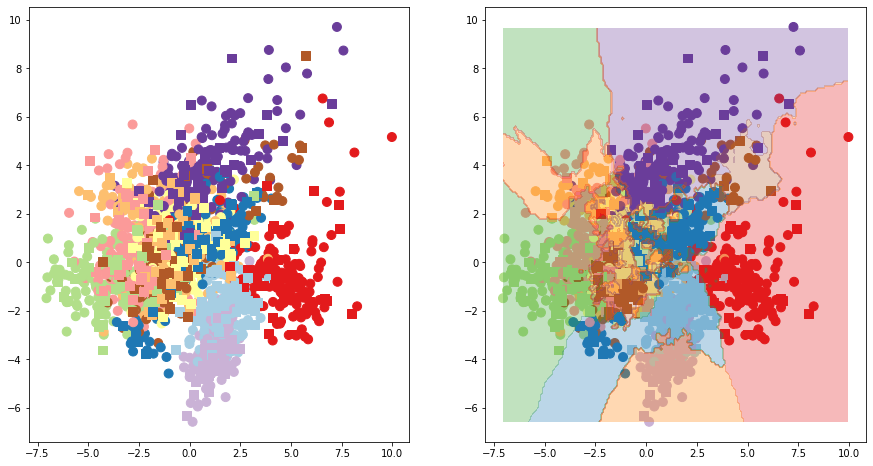

In [32]:
dimensions = [2, 10, 30, 50]
time_grid = np.zeros(len(dimensions))
acc = np.zeros(len(dimensions))

migrid = {'n_neighbors':[3,5,7,9],'weights':['uniform','distance']}

for i, v in enumerate(dimensions):
    time_grid[i], acc[i] = modKNNleave(v,migrid,y_test,y_train, X_test, X_train)

df_time['KNN LeaveOneOut'] = time_grid
df_accuracy['KNN LeaveOneOut'] = acc

This method is the extreme edition of K-fold with K = number training sample.

### Other Models

In [33]:
def modbayes(ytest,ytrain,xtest,xtrain):
    mignb = GaussianNB()
    mignb.fit(xtrain,ytrain)
    y_pred = mignb.predict(xtest)  
    print('Naive Bayes Model accuracy:',100*accuracy_score(ytest,y_pred))

In [34]:
modbayes(y_test,y_train, X_test, X_train)

Naive Bayes Model accuracy: 71.66666666666667


In [35]:
def modtree(n,ytest,ytrain,xtest,xtrain):
    miPCA = PCA(n_components=n)
    miPCA.fit(X_train)
    X_train_pca = miPCA.transform(X_train)
    X_test_pca = miPCA.transform(X_test)
    
    mimod = DecisionTreeClassifier()
    migrid = {'max_depth':[3,5,7,9]}
    migscv = GridSearchCV(estimator=mimod,param_grid=migrid,scoring='accuracy',cv=10, n_jobs=-1)
    migscv.fit(X_train_pca,ytrain)
    miknnopt = migscv.best_estimator_
    miknnopt.fit(X_train_pca,ytrain)
    y_pred = miknnopt.predict(X_test_pca)
    
    test_acc = 100*accuracy_score(ytest,y_pred)
    print(test_acc, 'Decision Tree Model with n_components: ',n)
    
    t = sum(migscv.cv_results_['mean_score_time']) + sum(migscv.cv_results_['mean_fit_time'])
    
    if(n==2):
        plt.figure(figsize=(15, 8))
        plt.subplot(121)
        plt.scatter(X_train_pca[:,0],X_train_pca[:,1],s=80,c=ytrain,cmap='Paired')
        
        X_test_pca = miPCA.transform(xtest)
        plt.scatter(X_test_pca[:,0],X_test_pca[:,1],s=80,marker='s',c=ytest,cmap='Paired')
        
        plt.subplot(122)
        plt.scatter(X_train_pca[:,0],X_train_pca[:,1],s=80,c=ytrain,cmap='Paired')
        plt.scatter(X_test_pca[:,0],X_test_pca[:,1],s=80,marker='s',c=y_pred,cmap='Paired')
        
        x_min, x_max = X_train_pca[:, 0].min(), X_train_pca[:, 0].max()
        y_min, y_max = X_train_pca[:, 1].min(), X_train_pca[:, 1].max()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
        
        Z = miknnopt.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        plt.contourf(xx, yy, Z, alpha=0.3,cmap='Paired')
        
    return t,test_acc

51.11111111111111 Decision Tree Model with n_components:  2
78.33333333333333 Decision Tree Model with n_components:  10
79.72222222222223 Decision Tree Model with n_components:  30
80.55555555555556 Decision Tree Model with n_components:  50


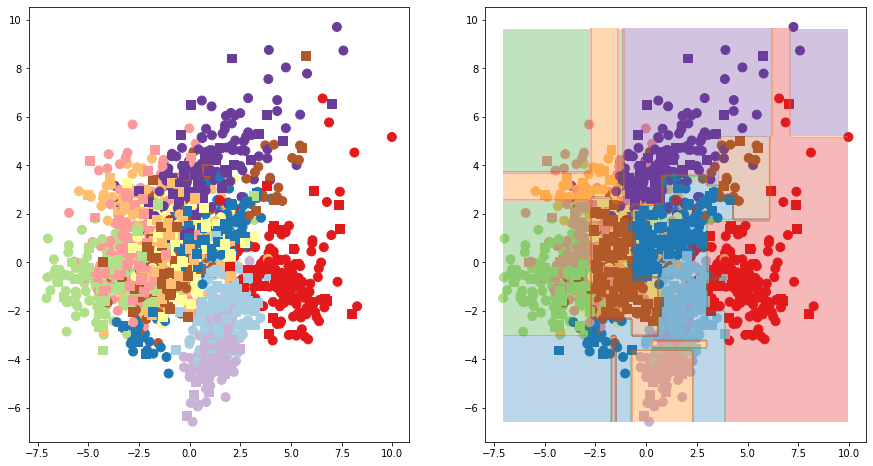

In [36]:
dimensions = [2, 10, 30, 50]
time_grid = np.zeros(len(dimensions))
acc = np.zeros(len(dimensions))

for i, v in enumerate(dimensions):
    time_grid[i], acc[i] = modtree(v,y_test,y_train, X_test, X_train)

df_time['Decision Tree'] = time_grid
df_accuracy['Decision Tree'] = acc

In [37]:
def modSVC(n,ytest, ytrain, xtest, xtrain):
    miPCA = PCA(n_components=n)
    miPCA.fit(xtrain)
    X_train_pca = miPCA.transform(xtrain)
    X_test_pca = miPCA.transform(xtest)
    miModelo = SVC()
    migrid = {'C': np.logspace(-2, 4, 7), 'gamma': np.logspace(-4, 4, 9)}
    migscv = GridSearchCV(estimator=miModelo,param_grid=migrid,scoring='accuracy',cv=10,n_jobs=-1)
    migscv.fit(X_train_pca,y_train)
    midtopt = migscv.best_estimator_
    midtopt.fit(X_train_pca,ytrain)
    y_pred = midtopt.predict(X_test_pca)  
    
    test_acc = 100*accuracy_score(ytest,y_pred)
    
    print('SVC Model accuracy: ' + str(test_acc) + ' / ' + str(n))
    
    t = sum(migscv.cv_results_['mean_score_time']) + sum(migscv.cv_results_['mean_fit_time'])
    
    if(n==2):
        plt.figure(figsize=(15, 8))
        plt.subplot(121)
        plt.scatter(X_train_pca[:,0],X_train_pca[:,1],s=80,c=ytrain,cmap='Paired')
        
        X_test_pca = miPCA.transform(xtest)
        plt.scatter(X_test_pca[:,0],X_test_pca[:,1],s=80,marker='s',c=ytest,cmap='Paired')
        
        plt.subplot(122)
        plt.scatter(X_train_pca[:,0],X_train_pca[:,1],s=80,c=ytrain,cmap='Paired')
        plt.scatter(X_test_pca[:,0],X_test_pca[:,1],s=80,marker='s',c=y_pred,cmap='Paired')
        
        x_min, x_max = X_train_pca[:, 0].min(), X_train_pca[:, 0].max()
        y_min, y_max = X_train_pca[:, 1].min(), X_train_pca[:, 1].max()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
        
        Z = midtopt.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        plt.contourf(xx, yy, Z, alpha=0.3,cmap='Paired')
        
    return t,test_acc

SVC Model accuracy: 57.77777777777777 / 2
SVC Model accuracy: 94.44444444444444 / 10
SVC Model accuracy: 98.61111111111111 / 30
SVC Model accuracy: 97.5 / 50


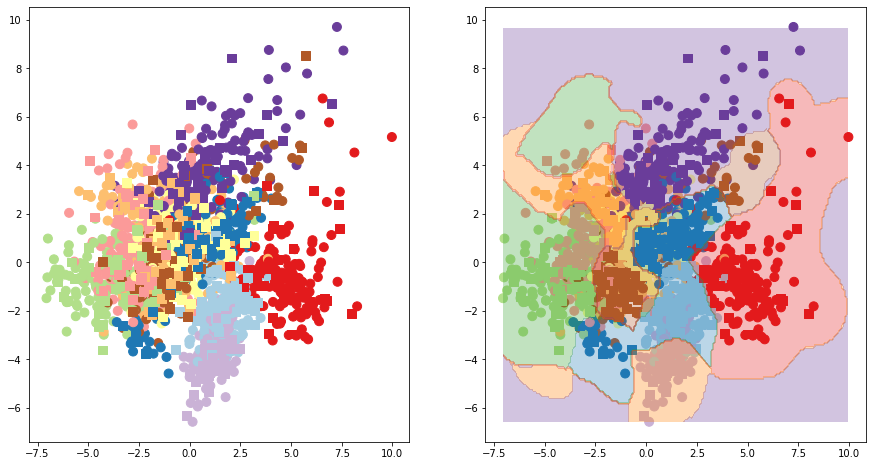

In [38]:
dimensions = [2, 10, 30, 50]
time_grid = np.zeros(len(dimensions))
acc = np.zeros(len(dimensions))

for i, v in enumerate(dimensions):
    time_grid[i], acc[i] = modSVC(v,y_test,y_train, X_test, X_train)

df_time['SVC'] = time_grid
df_accuracy['SVC'] = acc

In [39]:
def neuralnetwork (n, ytest, ytrain, xtest, xtrain):
    miPCA = PCA(n_components=n)
    miPCA.fit(xtrain)
    X_train_pca = miPCA.transform(xtrain)
    X_test_pca = miPCA.transform(xtest)
    
    miNN = MLPClassifier()    
    migrid = {'hidden_layer_sizes':[(5,5),(10,10),(10,5),(5,),(10)],
              'activation': ['logistic', 'tanh']} 
    migscv = GridSearchCV(estimator=miNN,param_grid=migrid,scoring='accuracy',cv=10, n_jobs=4)
    migscv.fit(X_train_pca,ytrain)
    midtopt = migscv.best_estimator_
    midtopt.fit(X_train_pca,ytrain)    
    y_pred = midtopt.predict(X_test_pca)  
    
    test_acc = 100*accuracy_score(ytest,y_pred)
    
    print('Neural Network accuracy: ' + str(test_acc) + ' / ' + str(n))
    
    t = sum(migscv.cv_results_['mean_score_time']) + sum(migscv.cv_results_['mean_fit_time'])
    
    if(n==2):
        plt.figure(figsize=(15, 8))
        plt.subplot(121)
        plt.scatter(X_train_pca[:,0],X_train_pca[:,1],s=80,c=ytrain,cmap='Paired')
        
        X_test_pca = miPCA.transform(xtest)
        plt.scatter(X_test_pca[:,0],X_test_pca[:,1],s=80,marker='s',c=ytest,cmap='Paired')
        
        plt.subplot(122)
        plt.scatter(X_train_pca[:,0],X_train_pca[:,1],s=80,c=ytrain,cmap='Paired')
        plt.scatter(X_test_pca[:,0],X_test_pca[:,1],s=80,marker='s',c=y_pred,cmap='Paired')
        
        x_min, x_max = X_train_pca[:, 0].min(), X_train_pca[:, 0].max()
        y_min, y_max = X_train_pca[:, 1].min(), X_train_pca[:, 1].max()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
        
        Z = midtopt.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        plt.contourf(xx, yy, Z, alpha=0.3,cmap='Paired')
        
    return t, test_acc

/home/master/Aplicaciones/anaconda/envs/master/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/master/Aplicaciones/anaconda/envs/master/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Network accuracy: 56.94444444444444 / 2


/home/master/Aplicaciones/anaconda/envs/master/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/master/Aplicaciones/anaconda/envs/master/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Network accuracy: 88.61111111111111 / 10


/home/master/Aplicaciones/anaconda/envs/master/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/master/Aplicaciones/anaconda/envs/master/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Network accuracy: 95.0 / 30


/home/master/Aplicaciones/anaconda/envs/master/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/master/Aplicaciones/anaconda/envs/master/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Network accuracy: 93.61111111111111 / 50


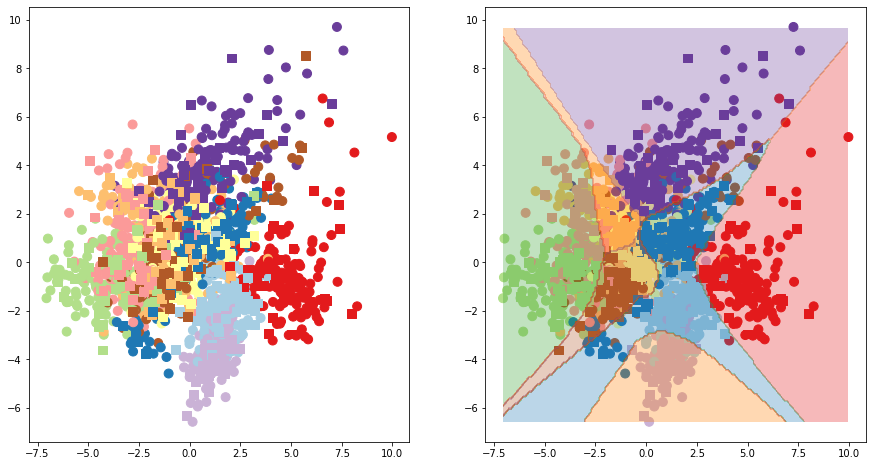

In [40]:
dimensions = [2, 10, 30, 50]
time_grid = np.zeros(len(dimensions))
acc = np.zeros(len(dimensions))

for i, v in enumerate(dimensions):
    time_grid[i], acc[i] = neuralnetwork(v,y_test,y_train, X_test, X_train)

df_time['ANN'] = time_grid
df_accuracy['ANN'] = acc

In [41]:
def ADABoost(n, ytest, ytrain, xtest, xtrain):
    miPCA = PCA(n_components=n)
    miPCA.fit(xtrain)
    X_train_pca = miPCA.transform(xtrain)
    X_test_pca = miPCA.transform(xtest)
    miModelo = AdaBoostClassifier()    
    migrid = {'n_estimators':[10,30,50,100]}
    migscv = GridSearchCV(estimator=miModelo,param_grid=migrid,scoring='accuracy',cv=10,n_jobs=-1)
    migscv.fit(X_train_pca,ytrain)
    midtopt = migscv.best_estimator_
    midtopt.fit(X_train_pca,ytrain)
    y_pred = midtopt.predict(X_test_pca)
    
    test_acc = 100*accuracy_score(ytest,y_pred)
    
    print("Accuracy " + str(test_acc) + " / " + str(n))
    
    t = sum(migscv.cv_results_['mean_score_time']) + sum(migscv.cv_results_['mean_fit_time'])
    
    if(n==2):
        plt.figure(figsize=(15, 8))
        plt.subplot(121)
        plt.scatter(X_train_pca[:,0],X_train_pca[:,1],s=80,c=ytrain,cmap='Paired')
        
        X_test_pca = miPCA.transform(xtest)
        plt.scatter(X_test_pca[:,0],X_test_pca[:,1],s=80,marker='s',c=ytest,cmap='Paired')
        
        plt.subplot(122)
        plt.scatter(X_train_pca[:,0],X_train_pca[:,1],s=80,c=ytrain,cmap='Paired')
        plt.scatter(X_test_pca[:,0],X_test_pca[:,1],s=80,marker='s',c=y_pred,cmap='Paired')
        
        x_min, x_max = X_train_pca[:, 0].min(), X_train_pca[:, 0].max()
        y_min, y_max = X_train_pca[:, 1].min(), X_train_pca[:, 1].max()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
        
        Z = midtopt.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        plt.contourf(xx, yy, Z, alpha=0.3,cmap='Paired')
        
    return t,test_acc

Accuracy 21.944444444444443 / 2
Accuracy 23.88888888888889 / 10
Accuracy 23.88888888888889 / 30
Accuracy 23.88888888888889 / 50


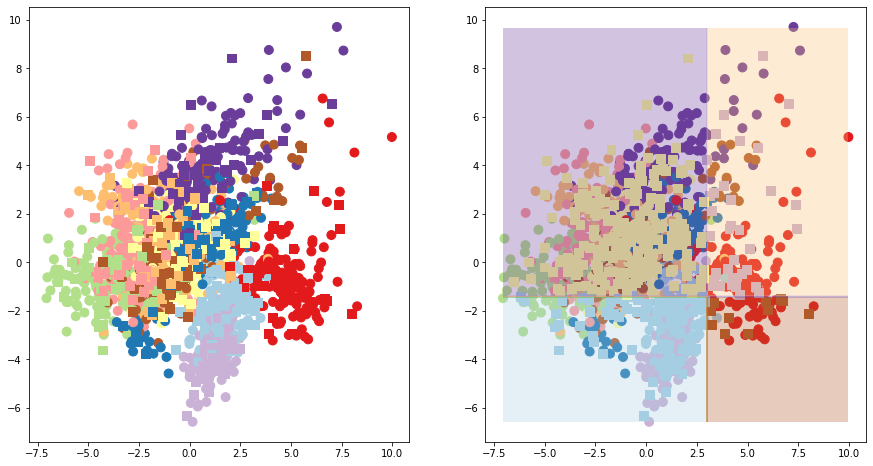

In [42]:
dimensions = [2, 10, 30, 50]
time_grid = np.zeros(len(dimensions))
acc = np.zeros(len(dimensions))

for i, v in enumerate(dimensions):
    time_grid[i], acc[i] = ADABoost(v,y_test,y_train, X_test, X_train)

df_time['ADA'] = time_grid
df_accuracy['ADA'] = acc

In [43]:
def modRF_PCA(n, ytest, ytrain, xtest, xtrain):
    miPCA = PCA(n_components=n)
    miPCA.fit(xtrain)
    X_train_pca = miPCA.transform(xtrain)
    X_test_pca = miPCA.transform(xtest)
    
    miModelo = RandomForestClassifier()    
    migrid = {'n_estimators':[10,30,50,100]}
    migscv = GridSearchCV(estimator=miModelo,param_grid=migrid,scoring='accuracy',cv=10,n_jobs=-1)
    migscv.fit(X_train_pca,y_train)
    midtopt = migscv.best_estimator_
    midtopt.fit(X_train_pca,y_train)
    y_pred = midtopt.predict(X_test_pca)    
    
    test_acc = 100*accuracy_score(y_test,y_pred)
    
    print('Random Forest Model accuracy:',test_acc)
    
    t = sum(migscv.cv_results_['mean_score_time']) + sum(migscv.cv_results_['mean_fit_time'])
    
    if(n==2):
        plt.figure(figsize=(15, 8))
        plt.subplot(121)
        plt.scatter(X_train_pca[:,0],X_train_pca[:,1],s=80,c=ytrain,cmap='Paired')
        
        X_test_pca = miPCA.transform(xtest)
        plt.scatter(X_test_pca[:,0],X_test_pca[:,1],s=80,marker='s',c=ytest,cmap='Paired')
        
        plt.subplot(122)
        plt.scatter(X_train_pca[:,0],X_train_pca[:,1],s=80,c=ytrain,cmap='Paired')
        plt.scatter(X_test_pca[:,0],X_test_pca[:,1],s=80,marker='s',c=y_pred,cmap='Paired')
        
        x_min, x_max = X_train_pca[:, 0].min(), X_train_pca[:, 0].max()
        y_min, y_max = X_train_pca[:, 1].min(), X_train_pca[:, 1].max()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
        
        Z = midtopt.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        plt.contourf(xx, yy, Z, alpha=0.3,cmap='Paired')
        
    return t,test_acc

Random Forest Model accuracy: 51.388888888888886
Random Forest Model accuracy: 92.22222222222223
Random Forest Model accuracy: 95.55555555555556
Random Forest Model accuracy: 95.55555555555556


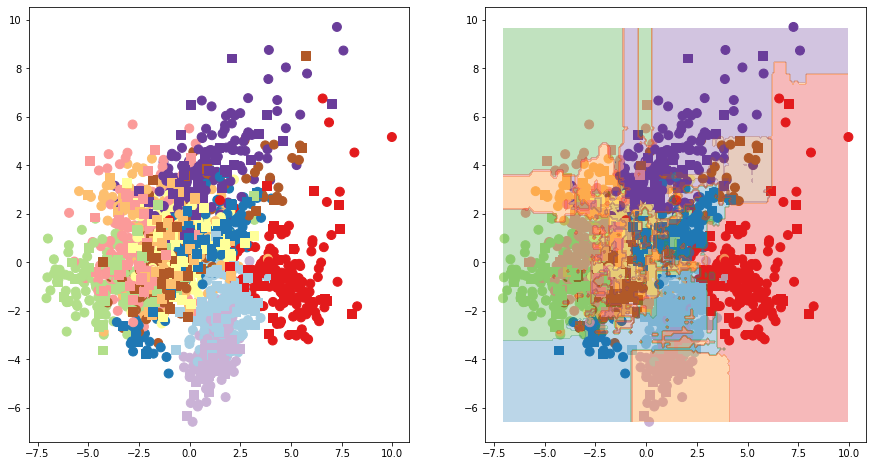

In [44]:
dimensions = [2, 10, 30, 50]
time_grid = np.zeros(len(dimensions))
acc = np.zeros(len(dimensions))

for i, v in enumerate(dimensions):
    time_grid[i], acc[i] = modRF_PCA(v,y_test,y_train, X_test, X_train)

df_time['RDF'] = time_grid
df_accuracy['RDF'] = acc

In [45]:
# fig, ax = plt.subplots(figsize=(15,10))
# ax.set_xlabel('Dimensions')
# ax.set_ylabel('Time (s)')
# ax.set_title("Time training comparison")
# for i in range(1,df_time.shape[1]):
#     ax.plot(df_time.iloc[:,0],df_time.iloc[:,i],'o-',label=df_time.columns[i])
# ax.legend(loc='best')

# plt.show()

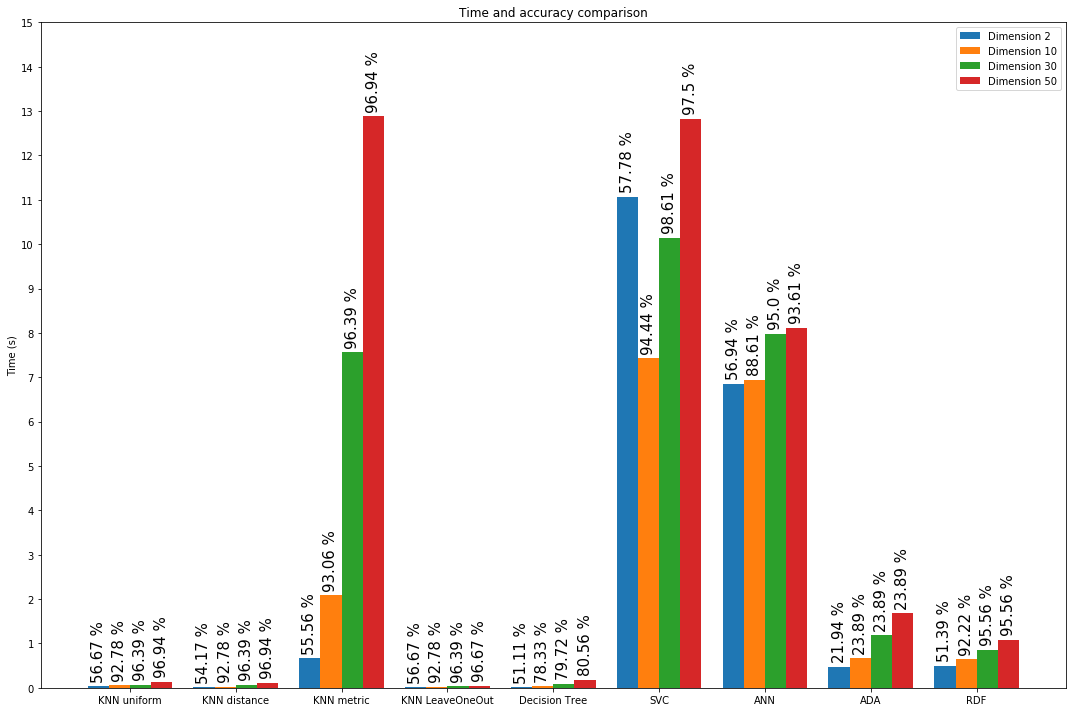

In [46]:
dim_bar = np.array([df_time.iloc[0,1:],df_time.iloc[1,1:],df_time.iloc[2,1:],df_time.iloc[3,1:]])
labels = list(df_time.columns)

ind = np.arange(dim_bar.shape[1])  # the x locations for the groups
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))

rects1 = ax.bar(ind - 3*width/2, dim_bar[0,:], width, label='Dimension 2')
rects2 = ax.bar(ind - width/2, dim_bar[1,:], width, label='Dimension 10')
rects3 = ax.bar(ind + width/2, dim_bar[2,:], width, label='Dimension 30')
rects4 = ax.bar(ind + 3*width/2, dim_bar[3,:], width, label='Dimension 50')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_xticks(ind)
ax.set_yticks(np.arange(0,16,1))
ax.set_xticklabels(labels[1:])
ax.set_title("Time and accuracy comparison")
ax.legend(loc='best')

def autolabel(rects, data):
    for idx,rect in enumerate(rects):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+0.1,
                str(np.round(data[idx],2))+" %",
                ha='center', va='bottom', rotation=90, fontsize=15)
        

autolabel(rects1, df_accuracy.iloc[0,1:])
autolabel(rects2, df_accuracy.iloc[1,1:])
autolabel(rects3, df_accuracy.iloc[2,1:])
autolabel(rects4, df_accuracy.iloc[3,1:])

# colors = ['tab:blue','tab:orange','tab:green','tab:red']
# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.set_ylabel('Accuracy')  # we already handled the x-label with ax1
# for i in range(3,-1,-1):
#     ax2.plot(labels[1:], df_accuracy.iloc[i,1:],'o-',color=colors[i])
        
# ax2.grid(True)
fig.tight_layout()

plt.show()

The graphs above represent the delay of the Grid Search process and the training and the accuracy of each models with the different dimensions. In the KNN model, the processing time increase with the number of candidates in the grid. In the other hand, the cross-validation process also seems to delay with more complex models. The percentages in the graph shows the accuracy on test of each model and dimensions. In this datasets it seems that the reduction to 2 dimensions is a huge mistake for the accuracy parameter, but the differences between 10 and 30/50 (similar in accuracy) dimensions are not very meaningful. The perfect model will be the KNN with any weight parameter with a reduction to 10 dimensions.

This is a "toy" dataset but in other case, the reduction of time to 10 dimensions to search the rigth params can be determinant.

## Abalone Dataset

We decide to choose the abalone dataset on the UCI Machine Learning Respository. It's about predicting the age (number of rings) of abalone from physical measurements. The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope.

Consists in 4177 instaces, with 8 attributes and 29 classes.

In [47]:
#Load the data
labels = ['Sex','Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight','Rings']
abalone = pd.read_csv("./data/abalone.data",header=None)
abalone.columns = labels
abalone

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


The first step of the preprocessing is to chagen any string value to a numeric value. In our case only the sex is in string format.
- M -> 0
- F -> 1
- I -> 2

In [48]:
abalone['Sex'] = abalone['Sex'].map({'M': 0, 'F': 1, 'I': 2})

We want to see some stadistics about each feature to select a right preprocessing model and group the different classes.

In [49]:
abalone.describe()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.955470,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.827815,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.000000,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,1.000000,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,2.000000,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,2.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


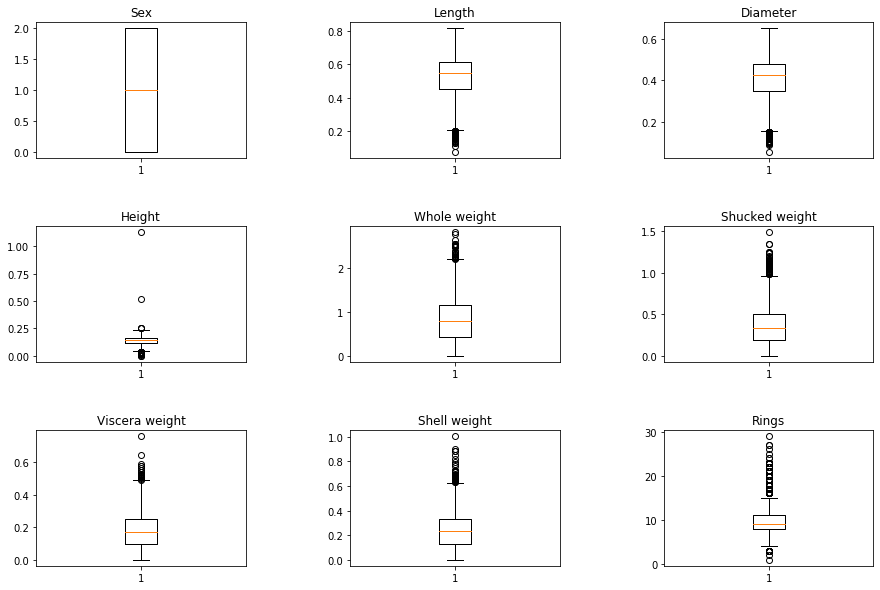

In [50]:
fig, axs = plt.subplots(3,3, figsize=(15,10))
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.ravel()

for i, feature in enumerate(abalone.columns):
    axs[i].boxplot(abalone[feature])
    axs[i].set_title(feature)

With this boxplot, we can see the distribution of each feature and the classes. Although, the range of the different features is not very distinct, for a better classification we will standardice it (not the sex).

Now, we want to see if the classes are well distributed.

In [51]:
abalone['Rings'].unique()

array([15,  7,  9, 10,  8, 20, 16, 19, 14, 11, 12, 18, 13,  5,  4,  6, 21,
       17, 22,  1,  3, 26, 23, 29,  2, 27, 25, 24])

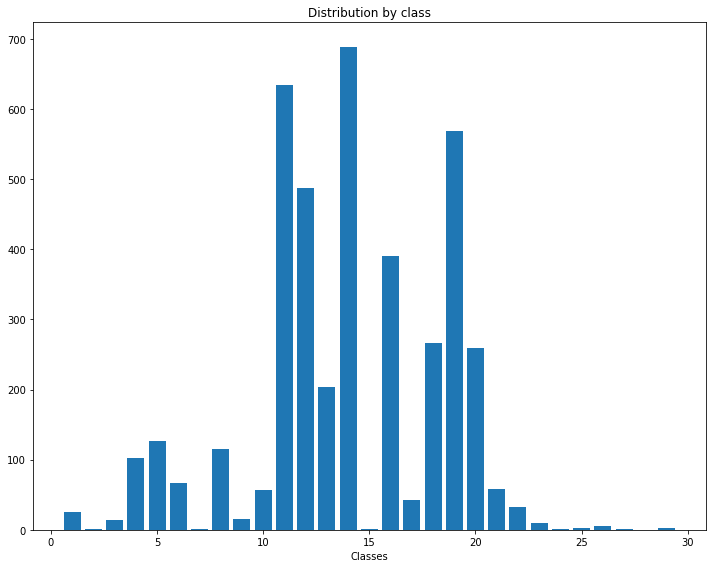

In [52]:
fig,ax = plt.subplots(figsize=(10,8))

ax.bar(abalone['Rings'].unique(),abalone.groupby(['Rings']).size())
ax.set_title("Distribution by class")
ax.set_xlabel("Classes")

fig.tight_layout()
plt.show()

With all the graphics bellow, it's neccesary stratified the data before the training to ensure that all classes are represented in the process. Also, we need to delete the data of those cases where there are only 1 or 2 examples for the correct performance of the process.

In [53]:
abalone.groupby(['Rings']).size() <= 2

Rings
1      True
2      True
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24     True
25     True
26     True
27     True
29     True
dtype: bool

There are 7 classes to delete: 1,2,24,25,26,27,28,29. This distribution tell us that there aren't many abalones in this ages.

In [54]:
idx1 = abalone[(abalone['Rings'] <= 2)].index
idx2 = abalone[(abalone['Rings'] >= 24)].index
abalone.drop(idx1, inplace=True)
abalone.drop(idx2, inplace=True)
abalone.shape

(4168, 9)

In [55]:
#Divide the dataset in X and Y
X = np.array(abalone.iloc[:,0:8])
y = np.array(abalone.iloc[:,8])

In [57]:
print(X.shape)
print(y.shape)

(4168, 8)
(4168,)


In [58]:
#Split train and data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12)
print(len(X_train), 'samples for training\n', \
     len(X_test), 'samples for test')

3334 samples for training
 834 samples for test


For the process of cross-validation we want to use all the models used before but in a pipeline format to do the standarization too.

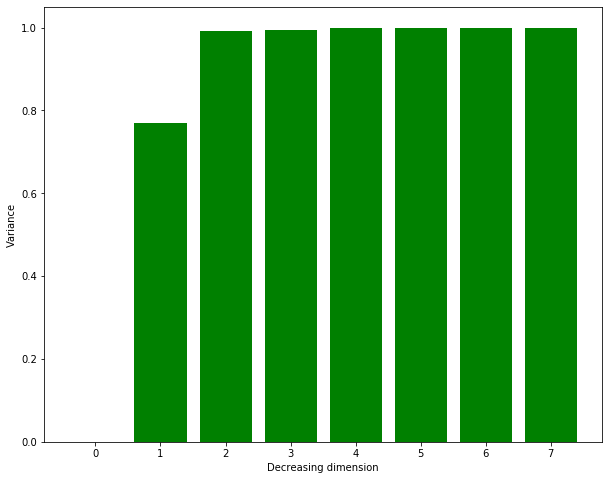

In [59]:
plot_lossPCA(X_train,X_test)

Plotting the variance while the dimensions of the datasets are decreasing show a different example of the previous dataset. In this dataset we won't reduce the data dimensions.

In [91]:
dict_classifiers = {
    "KNN": {
        'classifier': KNeighborsClassifier(),
        'params': [
            {
                'KNN__n_neighbors': [3,5,7,9],
                'KNN__weights': ['uniform', 'distance'],
                'KNN__p': [1,2,3,4,5]
            }
        ]
    },
    
    "DT": {
        'classifier': DecisionTreeClassifier(),
        'params': [
            {
                'DT__max_depth':[3,5,7,9]
            }
        ]
    },
    
    "SVM": {
        'classifier': SVC(),
        'params': [
            {
                'SVM__C': np.logspace(-2, 4, 7), 
                'SVM__gamma': np.logspace(-4, 4, 9)
            }
        ]
    },
    
    "NN": {
        'classifier': MLPClassifier(),
        'params': [
            {
                'NN__hidden_layer_sizes':[(15,15,15,15),(15,20,20,15),(15,20,15)],
                'NN__activation': ['logistic', 'tanh'],
                'NN__solver': ['lbfgs', 'sgd', 'adam'],
                'NN__max_iter': [1000]
            }
        ]
    },
    
    "ADA": {
        'classifier': AdaBoostClassifier(),
        'params': [
            {
                'ADA__n_estimators':[10,30,50,100]
            }
        ]
    },
    
    "RF": {
        'classifier': RandomForestClassifier(),
        'params': [
            {
                'RF__n_estimators':[10,30,50,100]
            }
        ]
    },
    
}

In [85]:
from sklearn.model_selection import learning_curve 
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.6, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

/home/master/Aplicaciones/anaconda/envs/master/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/master/Aplicaciones/anaconda/envs/master/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/master/Aplicaciones/anaconda/envs/master/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/master/Aplicaciones/anaconda/envs/master/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: Convergenc

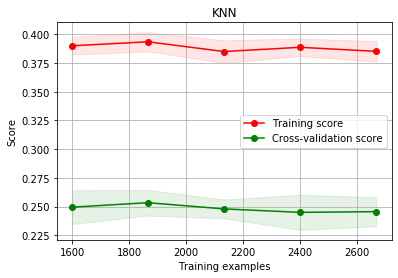

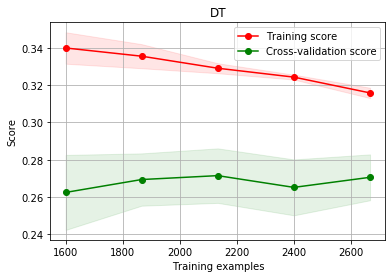

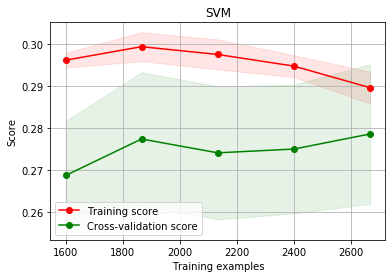

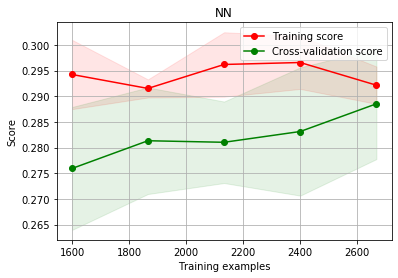

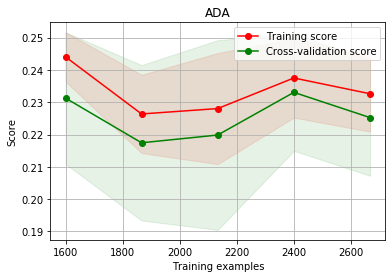

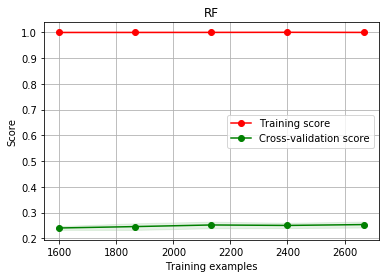

In [92]:
from sklearn.pipeline import Pipeline
labels = list(dict_classifiers.keys())
df_results = pd.DataFrame(
    data=np.zeros(shape=(len(labels),4)),
    columns=['classifier',
             'train_score', 
             'test_score',
             'training_time'])
 

for i, key in enumerate(labels):
    pl = Pipeline([('scaler', StandardScaler()),\
                   (key,\
                    dict_classifiers[key]['classifier'])])
    
    params = dict_classifiers[key]['params']
    
    gs = GridSearchCV(estimator=pl,param_grid=params,cv=5,scoring='accuracy',n_jobs=4)
    gs.fit(X_train,y_train)
    
    t = sum(gs.cv_results_['mean_score_time']) + sum(gs.cv_results_['mean_fit_time'])
    
    train_score = gs.best_estimator_.score(X_train,y_train)
    test_score = gs.best_estimator_.score(X_test,y_test)
    
    df_results.loc[i,'classifier'] = key
    df_results.loc[i,'train_score'] = train_score
    df_results.loc[i,'test_score'] = test_score
    df_results.loc[i,'training_time'] = t
    
    plot_learning_curve(gs.best_estimator_, 
                              "{}".format(key),
                              X_train,
                              y_train,
                              cv=5)
 

In [98]:
df_results

,classifier,train_score,test_score,training_time
0,KNN,0.385423,0.236211,2.528765
1,DT,0.310138,0.276978,0.035009
2,SVM,0.288842,0.261391,64.468356
3,NN,0.292142,0.276978,139.383049
4,ADA,0.237852,0.235012,0.967617
5,RF,0.999700,0.256595,1.007577


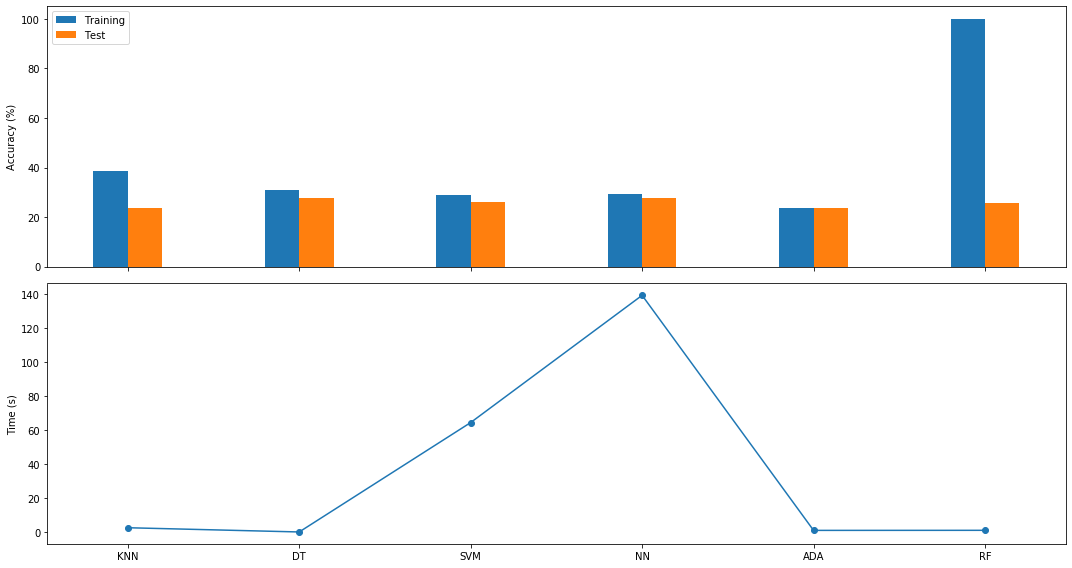

In [106]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,8),sharex=True)
labels = list(df_results.iloc[:,0])

ind = np.arange(len(labels))  # the x locations for the groups
width = 0.2  # the width of the bars

ax1.bar(ind - width/2, df_results.iloc[:,1]*100, width, label='Training')
ax1.bar(ind + width/2, df_results.iloc[:,2]*100, width, label='Test')

ax1.set_ylabel('Accuracy (%)')
ax1.set_xticks(ind)
ax1.legend(loc='best')

ax2.plot(ind, df_results.iloc[:,3],'o-')
ax2.set_ylabel('Time (s)')
ax2.set_xticks(ind)
ax2.set_xticklabels(labels)

fig.tight_layout()

plt.show()

This final graph shows how difficult is try to do automatic classification with a real dataset. Any of our model can reach the 30% of accuracy and, due to the number of parameters, the neural network and the support vector machine cross-validation process take a lot more time.

According to the <a href=https://pdfs.semanticscholar.org/a070/fb653c17798f886f2189045a8bc5556ab849.pdf>bibliography</a> a few models have achieved more than 30%.